In [1]:
from data_128 import *
from keras.models import load_model
from empatches import EMPatches
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from img_prcs import *
from skimage.morphology import (erosion, dilation, opening, closing, disk)
import matplotlib as mpl

In [2]:
test_path="/Users/behnaz/NCADD/prediction_cell_neurite/Prediction_pipeline_Cell+Neurite"
file_list = [f for f in os.listdir(test_path) if f[-3:]=="tif"]
print(file_list)
cell_model = load_model('DHM_Cell.hdf5')
neurite_model = load_model('DHM_Neurite.hdf5')

['XY_BG corrected_DHM_ROIs.tif', 'MAX_Fluo5439_CS1A1S1_Crop1.tif']
Metal device set to: Apple M1


In [3]:
img_DHM = img_read(test_path,file_list[0])
img_Fluo = img_read(test_path,file_list[1])

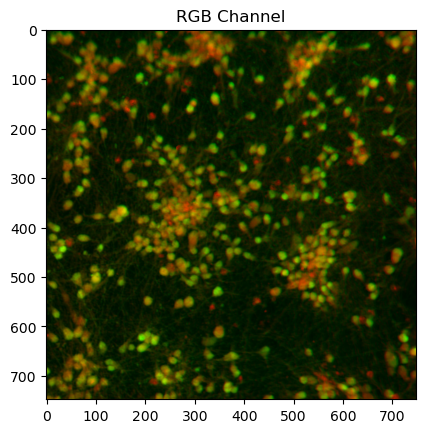

In [4]:
# Create an empty RGB image
height, width = img_DHM.shape
rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

# Assign the images to the blue and green channels
rgb_image[:, :, 0] = img_DHM  # Red channel
rgb_image[:, :, 1] = img_Fluo  # Green channel
rgb_image[:, :, 2] = np.zeros_like(img_Fluo) # Blue channel
plt.figure()
plt.imshow(rgb_image)
plt.title('RGB Channel')
plt.show()

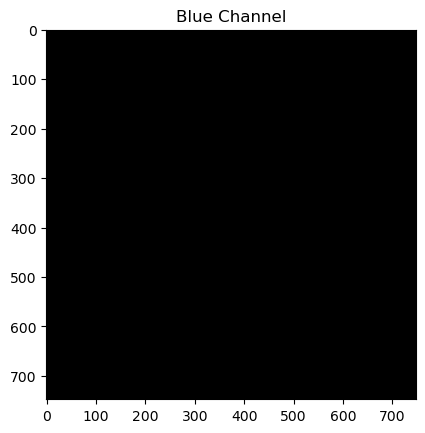

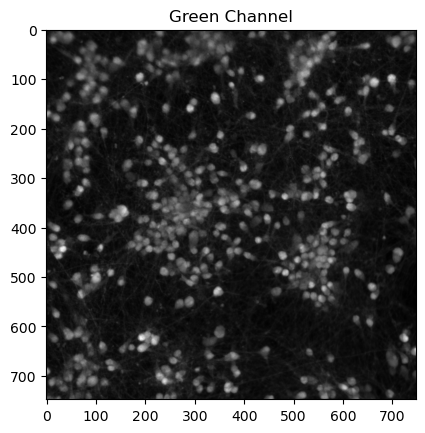

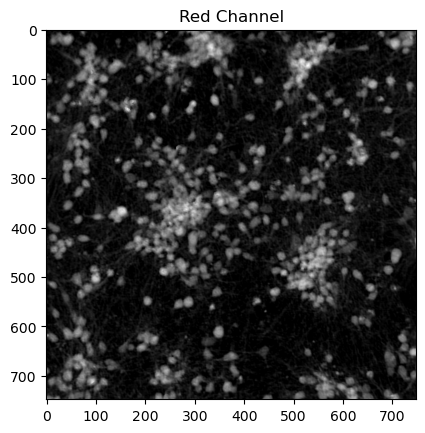

In [5]:
# Split the image into individual channels
blue_channel = rgb_image[:, :, 2]  # Blue channel
green_channel = rgb_image[:, :, 1]  # Green channel
red_channel = rgb_image[:, :, 0]  # Red channel
# Display the individual channels
plt.figure()
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')
plt.show()

plt.figure()
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')
plt.show()

plt.figure()
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')
plt.show()

In [46]:
emp = EMPatches()
img_patches_red, indices_red = emp.extract_patches(red_channel, patchsize=128, overlap=0.2) 

In [52]:
#Cell_prediction_red
NUM_TEST_IMAGES =len(img_patches_red)
testGene_r = testGenerators(img_patches_red)
c_results_r = cell_model.predict_generator(testGene_r, NUM_TEST_IMAGES,verbose=1)
cell_merged_img_r = emp.merge_patches(c_results_r, indices_red, mode='max')

 3/64 [>.............................] - ETA: 2s

/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2169/3891414262.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  c_results_r = cell_model.predict_generator(testGene_r, NUM_TEST_IMAGES,verbose=1)


64/64 [==============================] - 2s 38ms/step


In [53]:
emp = EMPatches()
img_patches_green, indices_green = emp.extract_patches(green_channel, patchsize=128, overlap=0.2) 

In [54]:
#Cell_prediction_green
NUM_TEST_IMAGES =len(img_patches_green)
testGene_g = testGenerators(img_patches_green)
c_results_g = cell_model.predict_generator(testGene_g, NUM_TEST_IMAGES,verbose=1)
cell_merged_img_g = emp.merge_patches(c_results_g,indices_green, mode='max')

 5/64 [=>............................] - ETA: 2s

/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2169/775361232.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  c_results_g = cell_model.predict_generator(testGene_g, NUM_TEST_IMAGES,verbose=1)


64/64 [==============================] - 2s 38ms/step


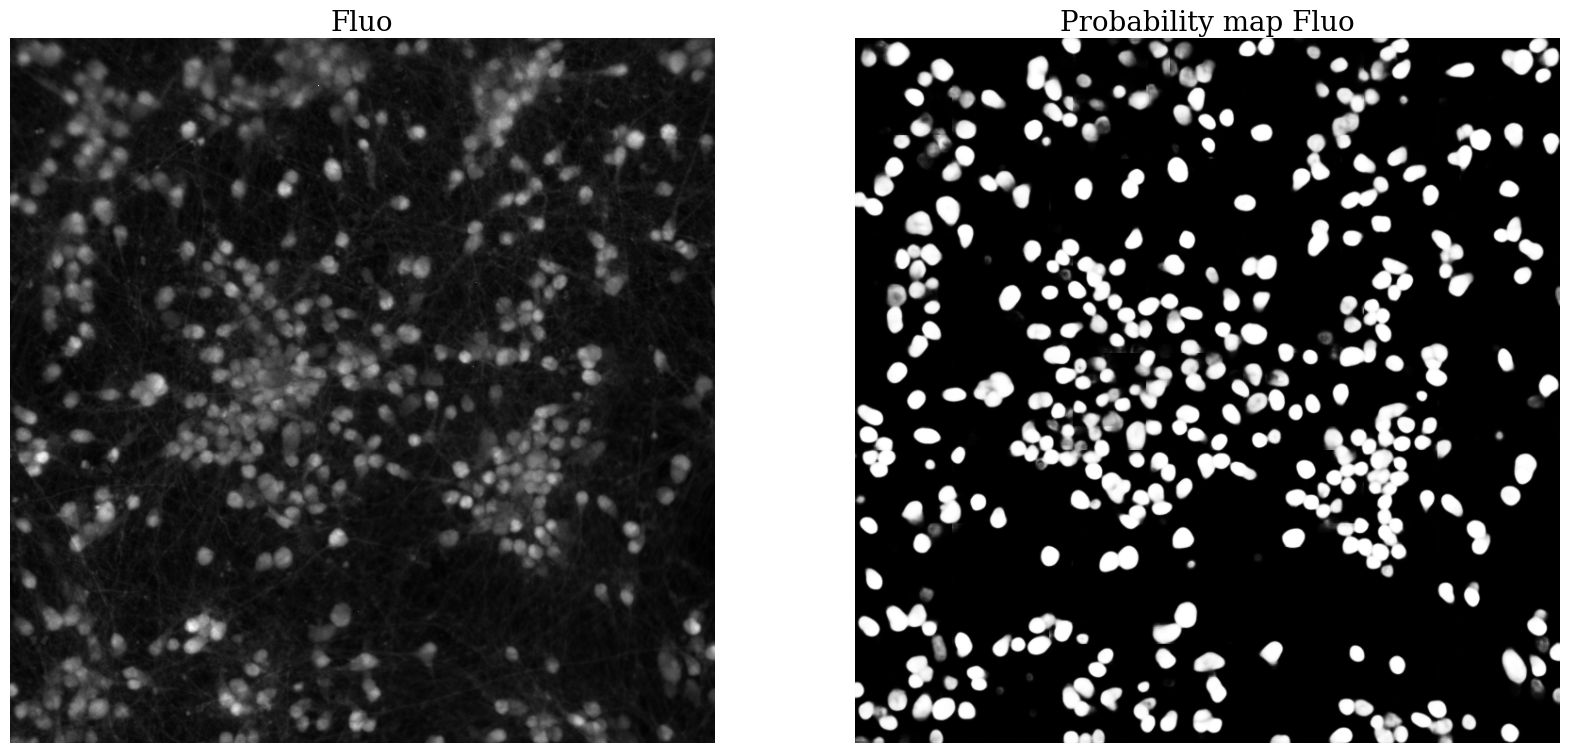

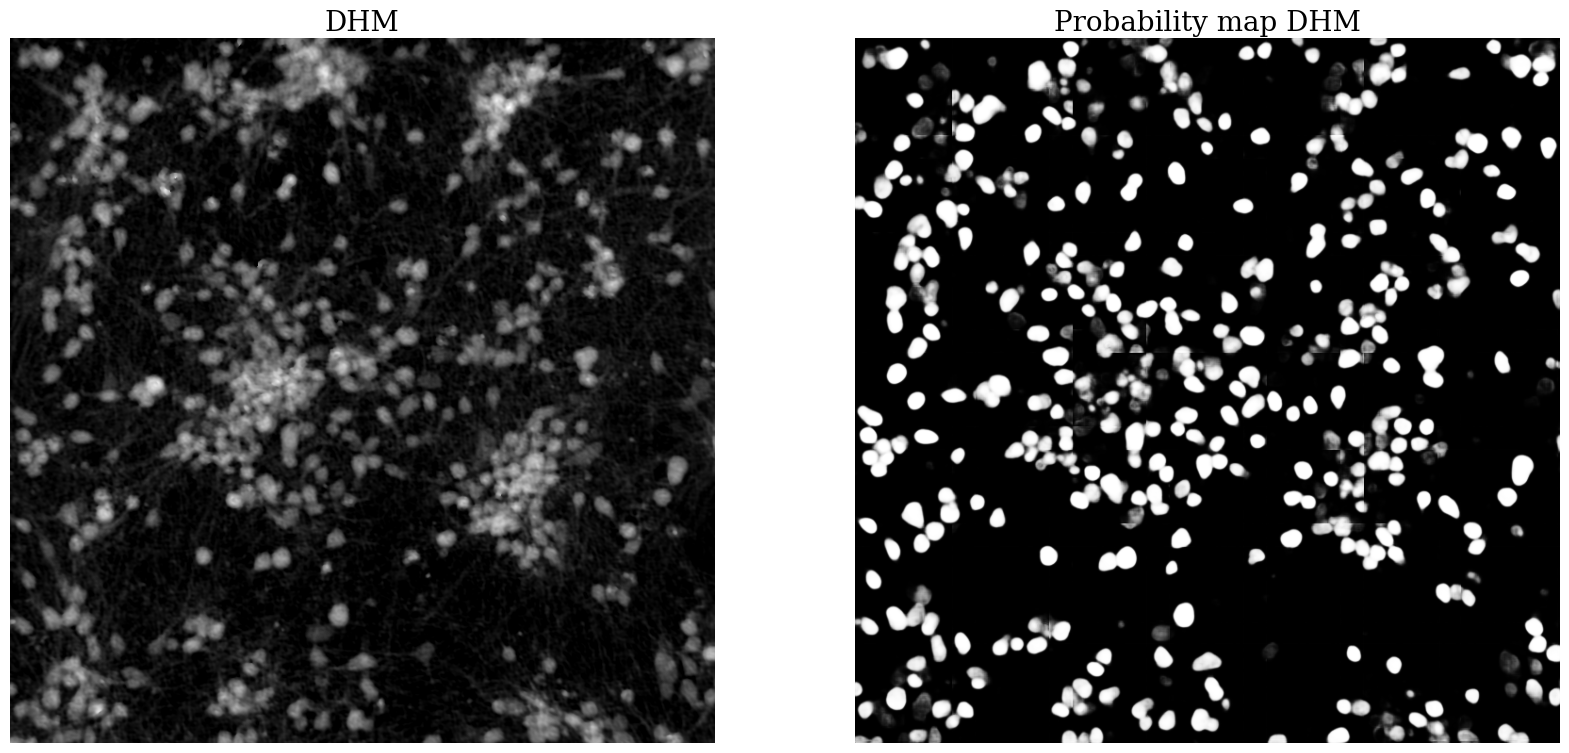

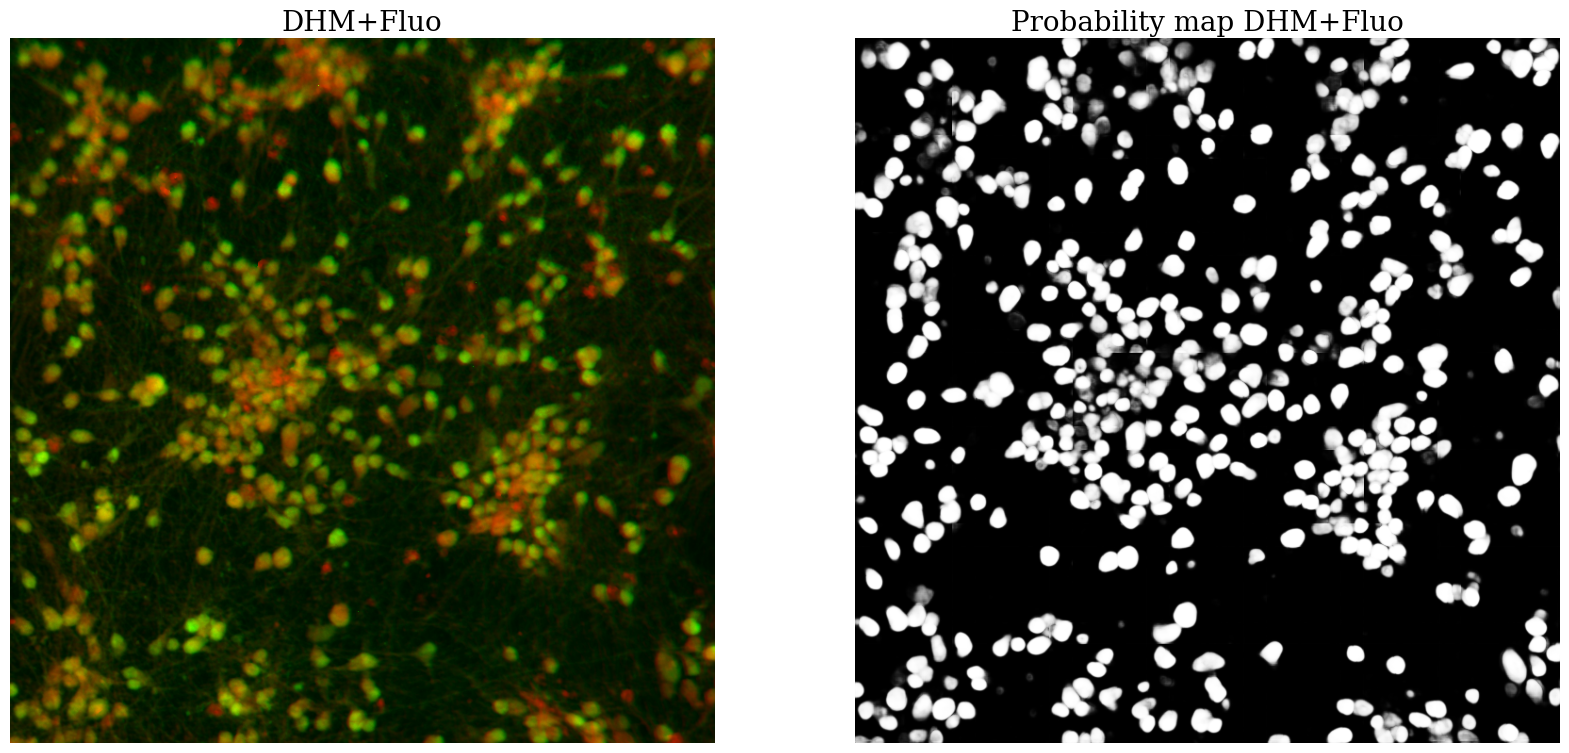

In [55]:
#visualising srt mask

plot_comparison(green_channel, cell_merged_img_g , 'Fluo','Probability map Fluo')
plot_comparison(red_channel, cell_merged_img_r , 'DHM','Probability map DHM')
plot_comparison(rgb_image, np.maximum(cell_merged_img_r, cell_merged_img_g) , 'DHM+Fluo','Probability map DHM+Fluo')
# plt.savefig('Cell_FOV2_Rat_4DIV.png')

Number of nuclei:  448


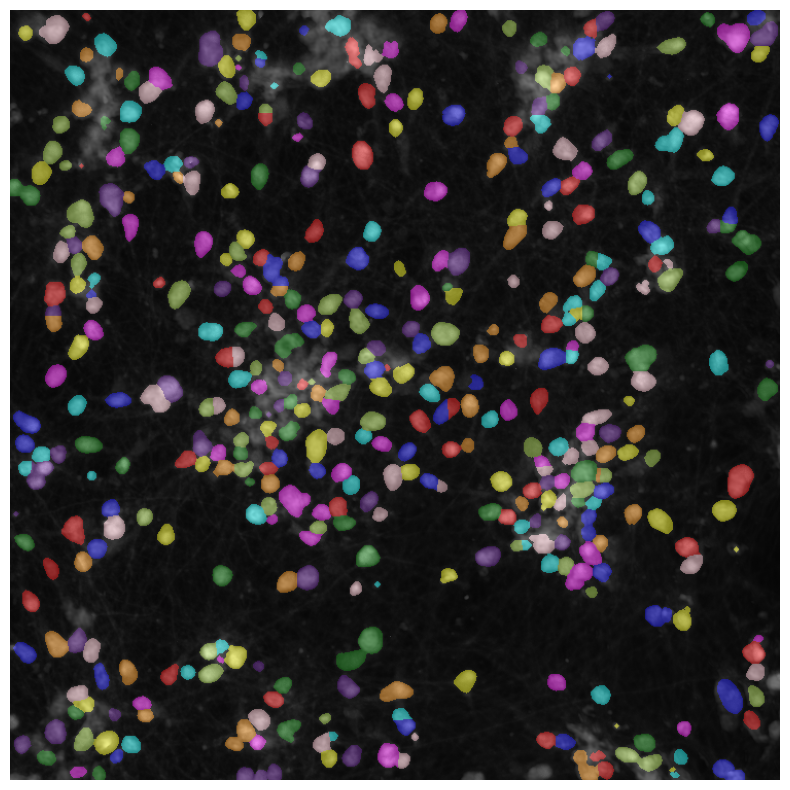

In [56]:
# Cell separation
Cell = Cell_Mask(np.maximum(cell_merged_img_r, cell_merged_img_g))
#Cell = Cell_Mask(cell_merged_img_b)
#Cell = Cell_Mask(cell_merged_img_g)
font2 = {'family':'serif','color':'black','size':20}
Cell_watershed = wtr_shed(Cell)
color_labels = color.label2rgb(Cell_watershed, rgb_image, alpha=0.4, bg_label=0)
print('Number of nuclei: ',Cell_watershed.max())
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(color_labels, cmap = 'Greys')
plt.axis('off')
#ax.set_title('Segmentation result over raw image. Number of Cells = %i'%((Cell_watershed.max())),fontdict = font2)
#plt.savefig('watershed.png',dpi=300)
plt.show()